In [100]:
import os
import math
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
from itertools import product

from sklearn.metrics import mean_squared_error, r2_score

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', length=14400, freq=None)

In [121]:
daily_data.shape

(480, 1, 11)

In [136]:
def window_mean(arr, num_steps, axis=1):
    assert num_steps < arr.shape[axis], f'num_steps ({num_steps}) must be a smaller than the length of the specified axis ({arr.shape[axis]})'
    assert arr.shape[axis] % num_steps == 0, f'num_steps must be a factor of the length of the specified axis ({arr.shape[axis]})'
    assert isinstance(num_steps, int), 'num_steps must be an integer'
    return np.array(np.split(arr, num_steps, axis=axis)).mean(axis=0).astype(np.float32)

def month_to_30(arr):
    if len(arr) > 30:
        return list(arr[:30])
    elif len(arr) < 30:
        return list(arr) + [arr[-1]] * (30 - len(arr))
    else:
        return list(arr)
    
def get_daily_range():
    tmp = pd.DataFrame(index=pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2018, 12, 31), freq='D'))
    tmp['month'] = [dt.month for dt in tmp.index]
    tmp['year'] = [dt.year for dt in tmp.index]
    daily_range = [month_to_30(arr.index) for month, arr in tmp.groupby(['year', 'month'])]
    return pd.DatetimeIndex(np.array(daily_range).flatten())

daily_data = np.load('../data/dailyt30_features.npy', allow_pickle=True)
monthly_data = np.load('../data/monthly_features.npy', allow_pickle=True)
daily_target = np.load('../data/dailyt30_target.npy', allow_pickle=True)
monthly_target = np.load('../data/monthly_target.npy', allow_pickle=True)
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')
daily_range = get_daily_range()

deseasonalize_X = True

if deseasonalize_X:
    # Daily
    for i in range(daily_data.shape[-1]):
        shape = daily_data[:, :, i].shape
        tmp = xr.DataArray(daily_data[:, :, i].flatten(), coords={'time': daily_range})
        climatologies = tmp.groupby('time.month').mean()
        daily_data[:, :, i] = (tmp.groupby('time.month') - climatologies).values.reshape(shape)
        
    # Monthly
    for i in range(monthly_data.shape[-1]):
        shape = monthly_data[:, :, i].shape
        tmp = xr.DataArray(monthly_data[:, :, i].flatten(), coords={'time': month_range})
        climatologies = tmp.groupby('time.month').mean()
        monthly_data[:, :, i] = (tmp.groupby('time.month') - climatologies).values.reshape(shape)

# Note that these must be factors of 30...
data = [
    daily_data,  # 1day
    window_mean(daily_data, 3),  # 3day
    window_mean(daily_data, 10),  # 10day
    window_mean(daily_data, 15),  # 15day
    monthly_data,  # 1mo (30day)
]

#Concatenate datasets and save lengths to pull them apart later
scales = [d.shape[1] for d in data]
data = np.concatenate(data, axis=1)

#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]
month_range = month_range[lag:]

In [137]:
test_years = 7  # Num years to use in testing

LEN_DATA = len(data)
NUM_TRAIN = LEN_DATA - (12*test_years)
NUM_TEST = LEN_DATA - NUM_TRAIN

print(f'{LEN_DATA=}', f'i.e. {LEN_DATA / 12:.1f} years')
print(f'{NUM_TRAIN=}', f'i.e. {NUM_TRAIN / 12:.1f} years')
print(f'{NUM_TEST=}', f'i.e. {NUM_TEST / 12:.1f} years')

x_train = data[:NUM_TRAIN]
x_test = data[NUM_TRAIN:]
y_train = monthly_target[:NUM_TRAIN]
y_test = monthly_target[NUM_TRAIN:]
month_range_train = month_range[:NUM_TRAIN]
month_range_test = month_range[NUM_TRAIN:]

LEN_DATA=479 i.e. 39.9 years
NUM_TRAIN=395 i.e. 32.9 years
NUM_TEST=84 i.e. 7.0 years


Text(0.5, 1.0, 'SIE')

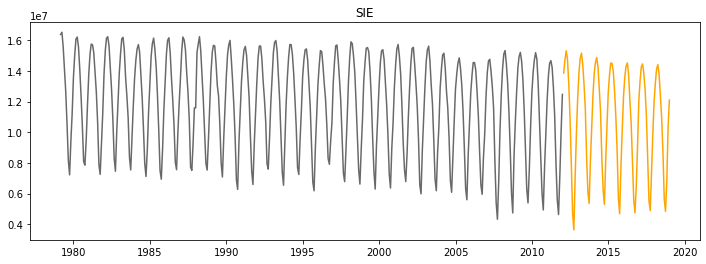

In [138]:
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.title('SIE')

Below cell deseasonalizes the SIE values by subtracting the average monthly SIE of the training dataset from both the train and test sets.

Text(0.5, 1.0, 'Deseasonalized SIE')

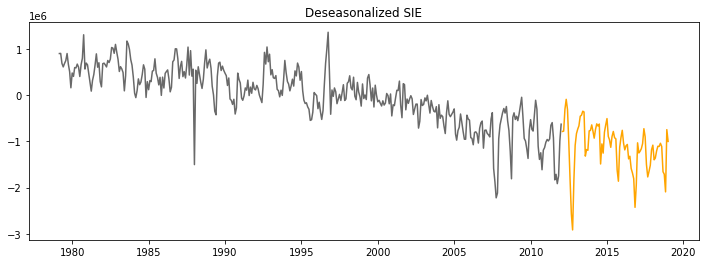

In [139]:
def deseasonalize(y_train, y_test, y_train_dates, y_test_dates):
    y_train = xr.DataArray(y_train, coords={'time': y_train_dates})
    y_test = xr.DataArray(y_test, coords={'time': y_test_dates})

    climatologies = y_train.groupby('time.month').mean()
    y_train = (y_train.groupby('time.month') - climatologies).values
    y_test = (y_test.groupby('time.month') - climatologies).values
    return y_train, y_test

y_train, y_test = deseasonalize(y_train, y_test, month_range_train, month_range_test)

plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.title('Deseasonalized SIE')

However we can clearly see a negative trend in the data, which should also be removed (likely an effect of climate change). Again the trend is found using the train set only, and applied to both train and test sets.

Text(0.5, 1.0, 'Deseasonalized and de-trended SIE')

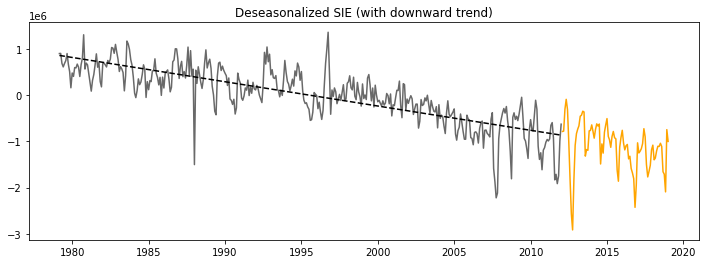

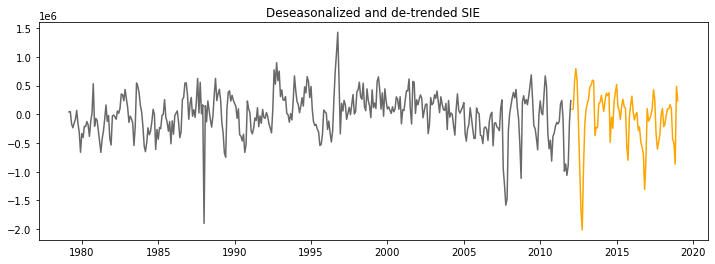

In [140]:
slope, intercept, r, p, se = stats.linregress(month_range_train.astype(int), list(y_train))

# Plot with trend
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.plot(month_range_train, intercept + slope * month_range_train.astype(int), 'k--')
plt.title('Deseasonalized SIE (with downward trend)')

# Remove trend
def detrend(y_train, y_test, y_train_dates, y_test_dates):
    slope, intercept, r, p, se = stats.linregress(month_range_train.astype(int), list(y_train))
    y_train = np.array(y_train - (intercept + slope * month_range_train.astype(int)))
    y_test = np.array(y_test - (intercept + slope * month_range_test.astype(int)))
    return y_train, y_test

y_train, y_test = detrend(y_train, y_test, month_range_train, month_range_test)
    
# Plot without trend
plt.figure(figsize=(12, 4))
plt.plot(month_range_train, y_train, 'dimgrey')
plt.plot(month_range_test, y_test, 'orange')
plt.title('Deseasonalized and de-trended SIE')

Test RMSE: 463,770.7
Test NRMSE: 0.0431
Test R_Square: 0.981


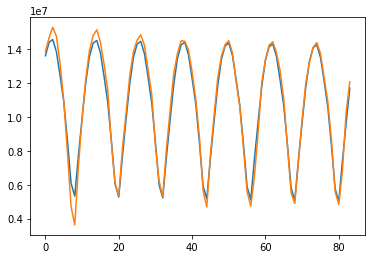

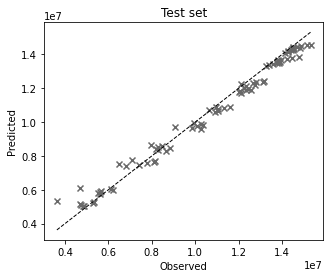

In [141]:
baseline_pred = xr.DataArray(np.zeros(shape=len(month_range_test)), coords={'time': month_range_test}).groupby('time.month') + climatologies
baseline_pred = baseline_pred + (intercept + slope * month_range_test.astype(int))

y_test_raw = monthly_target[NUM_TRAIN:]
plt.plot(baseline_pred)
plt.plot(y_test_raw)

# RMSE
rmse = math.sqrt(mean_squared_error(y_test_raw, baseline_pred))

# NRMSE
nrmse = rmse /(y_test_raw.mean()) 

# R2
r_sq = r2_score(y_test_raw, baseline_pred)

print(f'Test RMSE: {rmse:,.1f}')
print(f'Test NRMSE: {nrmse:.4f}')
print(f'Test R_Square: {r_sq:.3f}')

plt.figure(figsize=(5, 4))
plt.scatter(y_test_raw, baseline_pred, c='dimgrey', marker='x')
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'k--', lw=1)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Test set')

plt.show()

Converted from shape (18170, 11) to shape (395, 46, 11)
Converted from shape (3864, 11) to shape (84, 46, 11)


2022-03-07 18:54:29.654587: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-03-07 18:54:29.655775: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memo

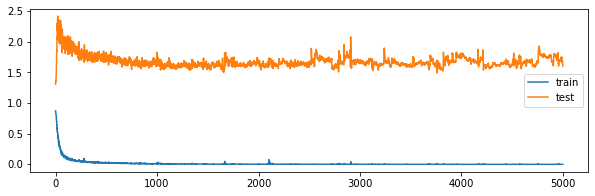

In [145]:
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    print(f'Converted from shape {dataset.shape} to shape {X.shape}')
    return X

timesteps = x_train.shape[1]

# Normalize the features, requires reshaping to 2D (?)
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2]))
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[2]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1))
y_test = scaler_l.transform(y_test.reshape(-1,1))

# Revert it back to 3D
x_train = reshape_features(x_train, timesteps)
x_test = reshape_features(x_test, timesteps)

# Build ensemble model
num_features = 11

# Loop over each time scale (e.g. 1, 3, 10, 15, 30)
models = []
models_inputs = []
for num_days in scales:
    model_input= Input(shape=(num_days, num_features))
    
    model = Permute((2,1), input_shape=(num_days, num_features))(model_input)
    model = LSTM(64, return_sequences=True, dropout=0.2)(model)
    model = LSTM(32, return_sequences=True, dropout=0.2)(model)
    model = LSTM(16, return_sequences=True, dropout=0.2)(model)
    model = Attention()(model)
    model = Dense(1)(model)
    
    models_inputs.append(model_input)
    models.append(model)

ensemble = concatenate(models)
merged_model = Dense(1)(ensemble)
model = Model(inputs=models_inputs, outputs=merged_model, name='EALSTM')

#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

# Model x input is a list of arrays corresponding to each timeframe, so split the concatenated dataset into its parts
x_train_sets = pull_apart(x_train, scales, axis=1)
x_train_sets = [d.astype('float32') for d in x_train_sets]

x_test_sets = pull_apart(x_test, scales, axis=1)
x_test_sets = [d.astype('float32') for d in x_test_sets]

history=model.fit(
    x_train_sets,
    y_train,
    epochs=5000,
    batch_size=64,
    verbose=0,
    validation_split=0.3,
    shuffle=True,)
    # callbacks=keras_callbacks)

plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

2022-03-07 19:13:23.180726: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-03-07 19:13:23.180973: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memo

Test RMSE: 1.4
Test NRMSE: -7.3561
Test R_Square: -0.135


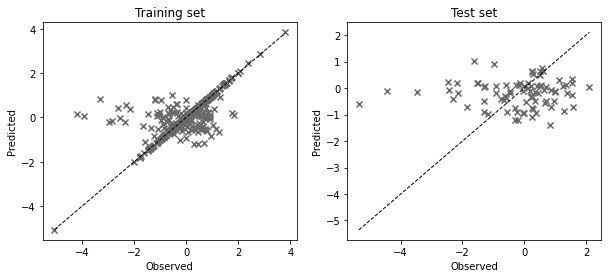

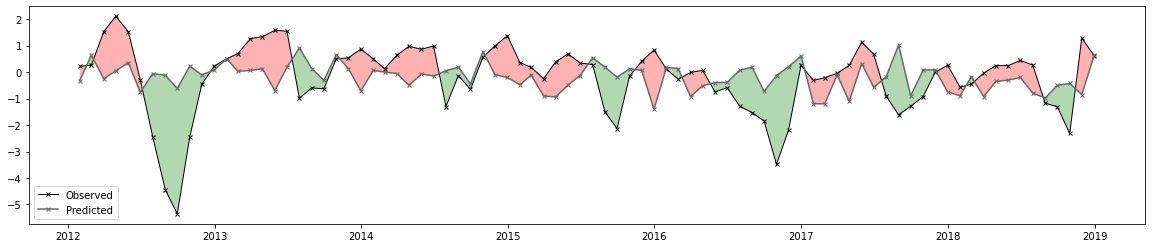

In [146]:
# Predict
pred_train = model.predict(x_train_sets)
pred_test = model.predict(x_test_sets)

# Inverse the transforms
pred_train_inv = scaler_l.inverse_transform(pred_train)
pred_test_inv = scaler_l.inverse_transform(pred_test)
y_test_inv = scaler_l.inverse_transform(y_test)
y_train_inv = scaler_l.inverse_transform(y_train)

# RMSE
rmse = math.sqrt(mean_squared_error(y_test_inv, pred_test_inv))

# NRMSE
y_max = y_test_inv.max()
y_min = y_test_inv.min()
nrmse = rmse /(y_test_inv.mean()) 

# R2
r_sq = r2_score(y_test, pred_test)

print(f'Test RMSE: {rmse:.1f}')
print(f'Test NRMSE: {nrmse:.4f}')
print(f'Test R_Square: {r_sq:.3f}')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(y_train, pred_train, c='dimgrey', marker='x')
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
axs[0].set_xlabel('Observed')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Training set')

axs[1].scatter(y_test, pred_test, c='dimgrey', marker='x')
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].set_title('Test set')

plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(month_range_test, y_test_inv, label='Observed', color='k', ls='-', lw=1, marker='x', markersize=4)
ax.plot(month_range_test, pred_test_inv, label='Predicted', color='dimgrey', lw=1.5, marker='x', markersize=4)
ax.fill_between(month_range_test, y_test_inv.flatten(), pred_test_inv.flatten(), where=(pred_test_inv<=y_test_inv).flatten(), facecolor='red', alpha=0.3, interpolate=True)
ax.fill_between(month_range_test, y_test_inv.flatten(), pred_test_inv.flatten(), where=(pred_test_inv>=y_test_inv).flatten(), facecolor='green', alpha=0.3, interpolate=True)
plt.legend()
plt.show()

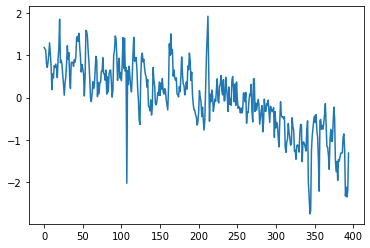

In [157]:
plt.plot(x_train_sets[-1][:, :, -1].flatten())

In [156]:
x_train_sets[-1].shape

(395, 1, 11)